<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Get-the-matrices" data-toc-modified-id="Get-the-matrices-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get the matrices</a></span></li><li><span><a href="#Viz-costs" data-toc-modified-id="Viz-costs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Viz costs</a></span></li></ul></li><li><span><a href="#Solve" data-toc-modified-id="Solve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solve</a></span><ul class="toc-item"><li><span><a href="#Studying-cases-from-matlab" data-toc-modified-id="Studying-cases-from-matlab-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Studying cases from matlab</a></span><ul class="toc-item"><li><span><a href="#Solving-the-linear-system" data-toc-modified-id="Solving-the-linear-system-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Solving the linear system</a></span></li></ul></li><li><span><a href="#Trying-to-&quot;trick&quot;-the-system-and-create-a-counter-example." data-toc-modified-id="Trying-to-&quot;trick&quot;-the-system-and-create-a-counter-example.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Trying to "trick" the system and create a counter example.</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

In [3]:
import numpy as np

# Description

# Load

The characteristics of the graph are loaded from Excel files. 

In [4]:
edges = pd.read_excel('cost_edges_3.xlsx')
inv_edges = pd.read_excel('inv_demand_3.xlsx')

In [5]:
edges['phi']=3

In [6]:
edges['k']=1

In [7]:
edges.loc[1:, 'phi'] = 50

In [8]:
edges.loc[0, 'phi'] = edges.loc[0, 'phi']*80/3
edges.loc[0, 'k'] = edges.loc[0, 'k']*80/3

In [9]:
gamma = 3/50

edges.loc[2, 'phi'] = edges.loc[2, 'phi']*gamma*4
edges.loc[2, 'k'] = edges.loc[2, 'k']*gamma*4

In [10]:
gamma = 50/500
edges.loc[3, 'phi'] = edges.loc[3, 'phi']*gamma
edges.loc[3, 'k'] = edges.loc[3, 'k']*gamma

In [11]:
gamma = 3/50

edges.loc[5, 'phi'] = edges.loc[5, 'phi']*gamma
edges.loc[5, 'k'] = edges.loc[5, 'k']*gamma

In [12]:
# edges.loc[3, 'phi'] = 140
edges.loc[3, 'phi'] = 50

In [13]:
edges

,origin,destination,phi,k
0,1,2,80.0,26.666667
1,2,1,50.0,1.000000
2,1,3,12.0,0.240000
3,3,1,50.0,0.100000
4,2,3,50.0,1.000000
5,3,2,3.0,0.060000


In [14]:
inv_edges['k'] = .5

In [15]:
inv_edges['shift'] = 15

In [16]:
inv_edges['phi']+=1

In [17]:
inv_edges.loc[:, 'shift'] = 0
inv_edges.loc[0, 'shift'] = 44
inv_edges.loc[3, 'shift'] = 35

In [18]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,2,0.5,44
1,2,1,4,0.5,0
2,3,1,3,0.5,0
3,1,3,5,0.5,35
4,2,3,2,0.5,0
5,3,2,4,0.5,0


## Get the matrices

In [19]:
alpha = 0.15

In [20]:
edges['A'] = edges['phi']/edges['k']/2 * alpha

In [21]:
edges

,origin,destination,phi,k,A
0,1,2,80.0,26.666667,0.225
1,2,1,50.0,1.000000,3.750
2,1,3,12.0,0.240000,3.750
3,3,1,50.0,0.100000,37.500
4,2,3,50.0,1.000000,3.750
5,3,2,3.0,0.060000,3.750


In [22]:
#order of edges in matlab
#edges = [1,2;1,3;2,1;2,3;3,1;3,2];
new_order = [0, 2, 1, 4, 3, 5]
edges.loc[new_order, 'A']

0     0.225
2     3.750
1     3.750
4     3.750
3    37.500
5     3.750
Name: A, dtype: float64

In [23]:
edges.loc[new_order, 'phi']

0    80.0
2    12.0
1    50.0
4    50.0
3    50.0
5     3.0
Name: phi, dtype: float64

In [24]:
inv_edges['D'] = inv_edges['phi']/inv_edges['k']/2 * alpha

In [25]:
inv_edges.loc[new_order, 'D']

0    0.30
2    0.45
1    0.60
4    0.30
3    0.75
5    0.60
Name: D, dtype: float64

In [26]:
inv_edges.loc[new_order, 'shift'] - inv_edges.loc[new_order, 'phi']

0    42
2    -3
1    -4
4    -2
3    30
5    -4
dtype: int64

## Viz costs

Visualize the costs for each OD pair specified in the Excels. 

In [27]:
# inv_edges['shift'] = inv_edges['shift']+15

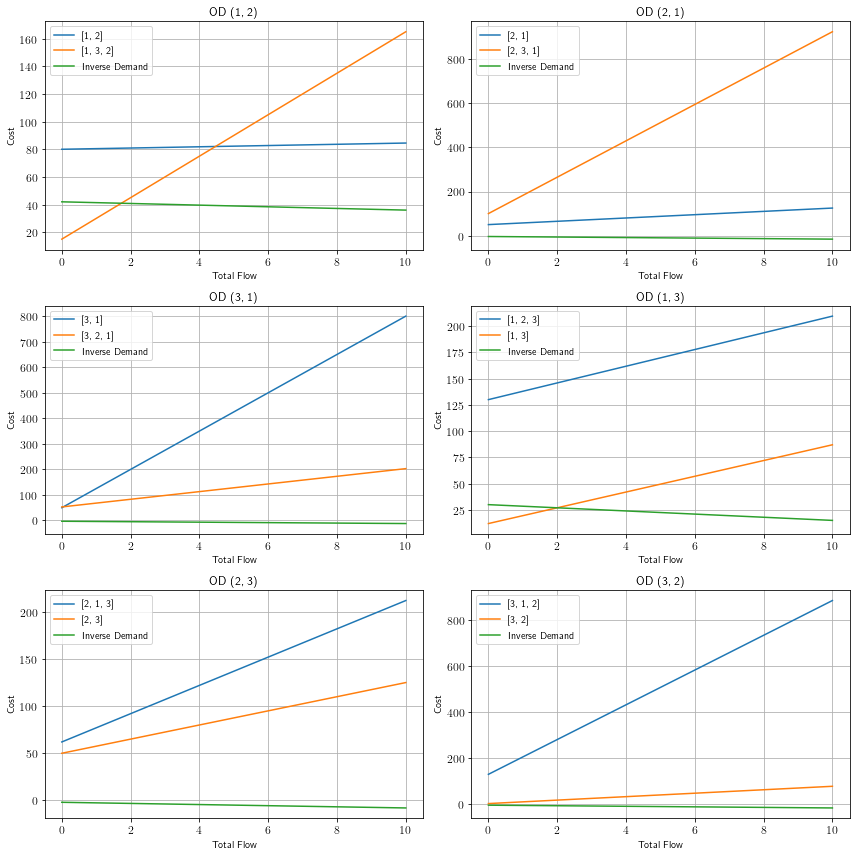

In [28]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

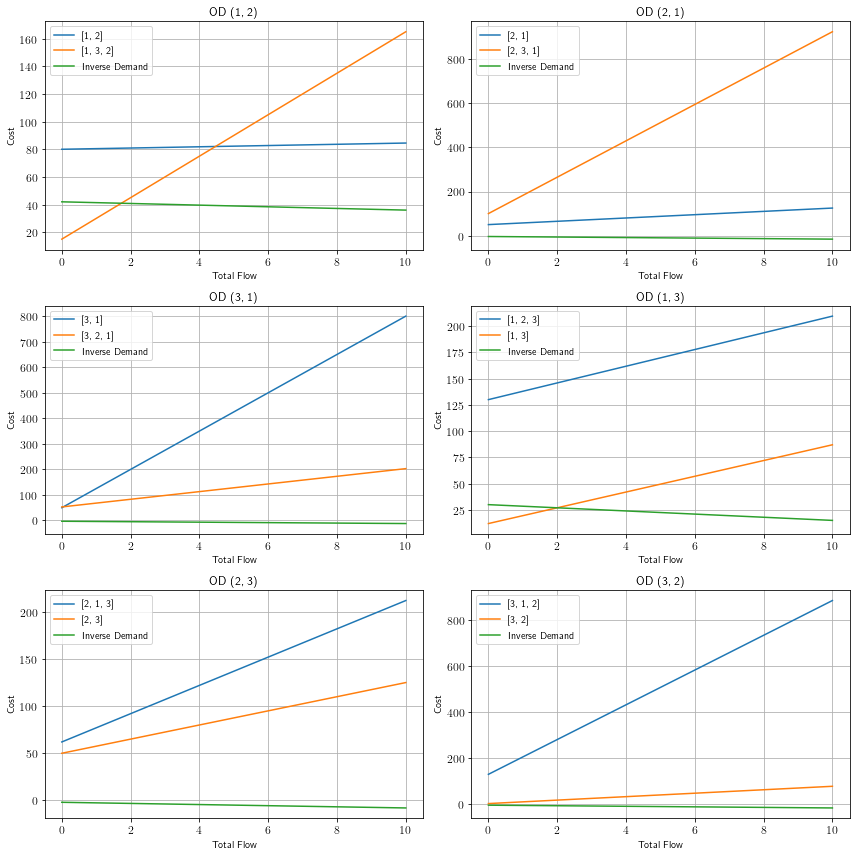

In [29]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

# Solve

In [30]:
correct = False

In [31]:
"""
Returns
-------
f_p: cvxpy.Variable
    The flow for each commodity on each edge
f_r: cvxpy.Variable
    The rebalancing flow on each edge
r: cvxpy.Parameter
    The rebalancing guess for each node
d_var: cvxpy.Variable
    The demand for each each
prob: cvxpy.Problem
    The optimization problem
map_comps: dict
    A map linking components of f_p to the edges and inv edges
map_edges: dict
    A map linking edges to components of f_p
costs_dict: dict
    Dict containing the cost for each edge
inv_demand_dict: dict
    The inverse demand cost for each od pair
G: nx.DiGraph
    Graph representing the network
nodes: list
    list of nodes
"""
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct, beta = 1)

/Users/lucasfuentes/miniconda3/envs/py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/lucasfuentes/miniconda3/envs/py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/lucasfuen

Specify a value of the rebalancing parameter

In [32]:
x = -1
y = 1

In [33]:
r_new = [x, -x-y, y]
r.value = r_new

You can then solve the problem. 

In [34]:
prob.solve(solver = cp.GUROBI)

Academic license - for non-commercial use only


38.63696275210746

Check the status. 

In [35]:
prob.status

'optimal'

Therefore, the below function helps in analyzing and decomposing edge by edge for the passenger flow. 

In [36]:
get_edge_flow(f_p, map_edges)

{(1, 2): 4.021091451111108e-12,
 (1, 3): 2.114613180524031,
 (2, 1): 4.983684238591613e-12,
 (2, 3): 4.852710955124168e-12,
 (3, 1): 3.4704453478133244e-12,
 (3, 2): 0.6876790831128278}

In [37]:
get_d_values(inv_edges, d_var)

{(1, 2): 0.6876790831102448,
 (2, 1): 1.956935699973838e-12,
 (3, 1): 2.124727261984369e-12,
 (1, 3): 1.4269340974128633,
 (2, 3): 2.3403567022329006e-12,
 (3, 2): 3.487892278874176e-12}

In [38]:
edges

,origin,destination,phi,k,A
0,1,2,80.0,26.666667,0.225
1,2,1,50.0,1.000000,3.750
2,1,3,12.0,0.240000,3.750
3,3,1,50.0,0.100000,37.500
4,2,3,50.0,1.000000,3.750
5,3,2,3.0,0.060000,3.750


In [39]:
f_r.value

array([5.45197211e-13, 7.42693410e-01, 7.08125159e-13, 2.57306590e-01,
       1.14013327e-12, 7.42693410e-01])

In [40]:
kkt_rel_error = compute_error_KKT(G, costs_dict, inv_d_dict, inv_edges, map_comps, f_p)

In [41]:
kkt_rel_error

{(1, 2): [nan, 1.0000000000055884],
 (2, 1): [nan, nan],
 (3, 1): [nan, nan],
 (1, 3): [nan, 1.0000000000019684],
 (2, 3): [nan, nan],
 (3, 2): [nan, nan]}

We can also compute directly the new rebalancing guess. 

In [42]:
get_new_r(f_p, map_edges, nodes)

[-2.114613180519598, 0.6876790831070124, 1.4269340974125857]

## Studying cases from matlab

In [43]:
#we fix it to zero as we want to see which scenario we have
y = .65
r_list = []
Tr_list = []
for x in np.linspace(-.5, -.80, 10):
    r_new = [x, -x-y, y]
    r_list.append(r_new)
    r.value = r_new

    prob.solve(solver = cp.GUROBI)

    get_edge_flow(f_p, map_edges)

    get_d_values(inv_edges, d_var)

    Tr_list.append(get_new_r(f_p, map_edges, nodes))

In [44]:
rat_=[]
for i in range(len(r_list)):
    for j in range(i+1, len(r_list)):
        r1 = np.array(r_list[i])
        r2 = np.array(r_list[j])
        Tr1 = np.array(Tr_list[i])
        Tr2 = np.array(Tr_list[j])
        
        rat = np.linalg.norm(Tr1 - Tr2)/np.linalg.norm(r1-r2)
        rat_.append(rat)

In [45]:
rat_

[0.06647283156865068,
 0.06647283153866261,
 0.06647283299410217,
 0.06647283263479882,
 0.0664728315620127,
 0.0664728315457927,
 0.06647283153386277,
 0.06647283152470637,
 0.06647283151744669,
 0.06647283150867456,
 0.06647283370682792,
 0.06647283299018153,
 0.0664728315603532,
 0.06647283154122109,
 0.06647283152806477,
 0.06647283151842863,
 0.0664728315110462,
 0.06647283590498129,
 0.06647283373093502,
 0.06647283157757942,
 0.06647283154935774,
 0.0664728315319428,
 0.06647283152005429,
 0.066472831511385,
 0.06647283155688875,
 0.06647282941387848,
 0.06647283009748321,
 0.0664728304386832,
 0.0664728306430689,
 0.06647283077911896,
 0.06647282727086823,
 0.06647282936778046,
 0.066472830065948,
 0.06647283041461394,
 0.06647283062356499,
 0.06647283146469267,
 0.06647283146348788,
 0.06647283146252916,
 0.06647283146173917,
 0.0664728314622831,
 0.0664728314614474,
 0.0664728314607547,
 0.06647283146061171,
 0.06647283145999047,
 0.06647283145936923]

### Solving the linear system

In [46]:
r_list

[[-0.5, -0.15000000000000002, 0.65],
 [-0.5333333333333333, -0.1166666666666667, 0.65],
 [-0.5666666666666667, -0.08333333333333337, 0.65],
 [-0.6, -0.050000000000000044, 0.65],
 [-0.6333333333333333, -0.01666666666666672, 0.65],
 [-0.6666666666666667, 0.01666666666666672, 0.65],
 [-0.7000000000000001, 0.050000000000000044, 0.65],
 [-0.7333333333333334, 0.08333333333333337, 0.65],
 [-0.7666666666666667, 0.1166666666666667, 0.65],
 [-0.8, 0.15000000000000002, 0.65]]

In [69]:
y_vec = [.6, .75, .8]
r_list = []
Tr_list = []
x_vec = [-.5, -1, -.25]
for i in range(3):
    x = x_vec[i]
    y = y_vec[i]
    r_new = [x, -x-y, y]
    r_list.append(r_new)
    r.value = r_new

    prob.solve(solver = cp.GUROBI)
    print("-------")
    print(get_edge_flow(f_p, map_edges))
    print(f_r.value)

    print(get_d_values(inv_edges, d_var))

    Tr_list.append(get_new_r(f_p, map_edges, nodes))

-------
{(1, 2): 6.021915831585139e-12, (1, 3): 2.1611747851205707, (2, 1): 7.483101391160228e-12, (2, 3): 6.5614642882983895e-12, (3, 1): 4.901318536322973e-12, (3, 2): 0.96704871058774}
[8.26714657e-13 2.94412607e-01 1.19039465e-12 2.05587393e-01
 1.63488678e-12 3.94412607e-01]
{(1, 2): 0.9670487105730883, (2, 1): 2.9720738328046055e-12, (3, 1): 3.2454937029314326e-12, (1, 3): 1.1941260745464073, (2, 3): 3.496422658909642e-12, (3, 2): 7.177433426864002e-12}
-------
{(1, 2): 5.092530655289927e-12, (1, 3): 2.1474450811942276, (2, 1): 5.8339685906838695e-12, (2, 3): 5.574704966629552e-12, (3, 1): 4.458720814273481e-12, (3, 2): 0.8846704871280554}
[6.88631357e-13 7.47110793e-01 9.41697384e-13 2.52889207e-01
 1.41053133e-12 4.97110793e-01]
{(1, 2): 0.8846704871129271, (2, 1): 2.408290645188292e-12, (3, 1): 2.788497808192322e-12, (1, 3): 1.262774594080546, (2, 3): 2.89998516496204e-12, (3, 2): 6.407576199261997e-12}
-------
{(1, 2): 2.4437107382729933e-14, (1, 3): 2.1319245463211036, (2, 1

In [48]:
b = np.zeros(4)
A = np.zeros((4,4))
for i in [0, 1]:
    dTr = np.array(Tr_list[i]) - np.array(Tr_list[i+1])
    dr = np.array(r_list[i]) - np.array(r_list[i+1])
    s = i*2
    drA = dr[:2]
    A[s, :2] = drA
    A[s+1, 2:] = drA
    b[s:s+2] = dTr[:2]

In [49]:
A

array([[ 0.5 , -0.35,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 , -0.35],
       [-0.75,  0.8 ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.75,  0.8 ]])

In [50]:
sol = np.linalg.solve(A, b)

In [51]:
A_sol = [[sol[0], sol[1]], [sol[2], sol[3]]]

In [52]:
np.around(A_sol, 4)


array([[-0.1194, -0.1313],
       [ 0.7163,  0.788 ]])

In [53]:
u, s, vh = np.linalg.svd(A_sol)

In [54]:
u

array([[-0.16439899,  0.98639392],
       [ 0.98639392,  0.16439899]])

In [55]:
s

array([1.07959367e+00, 8.71072207e-12])

In [56]:
vh

array([[ 0.67267279,  0.73994007],
       [-0.73994007,  0.67267279]])

We see that the sv is >1. Also, we don't match with the one from matlab
 -0.0809   -0.0890
    0.7550    0.8305
    
Questions
1. why don't we match with that from Matlab
2. how are we restricted actually in how we explore the space? (there is an implicit constraint on the rebalancing vector)

In [64]:
A_sol@vh[0,:]/s[0]

array([-0.16439899,  0.98639392])

In [65]:
np.linalg.norm(A_sol@vh[0,:])

1.0795936716292827

In [66]:
vh[0,:]

array([0.67267279, 0.73994007])

In [96]:
A_sol

[[-0.11938872977400726, -0.13132760274806363],
 [0.7163323780741186, 0.7879656159402322]]

2->3 dim mapping

In [97]:
A_p = np.array([[1,0],[0,1],[-1,-1]])

In [100]:
A_fin = A_p@A_sol

In [101]:
u_, s_, vh_ = np.linalg.svd(A_fin)

In [102]:
s_

array([1.39751125e+00, 1.16551703e-11])

In [103]:
u_

array([[-0.12700013, -0.80656107,  0.57734756],
       [ 0.76200076,  0.29329229,  0.57735125],
       [-0.63500063,  0.51326296,  0.57735199]])

In [104]:
vh_

array([[ 0.67267279,  0.73994007],
       [ 0.73994007, -0.67267279]])

## Trying to "trick" the system and create a counter example. 

In [70]:
r1 = r_list[0]

In [72]:
dv = [vh[0,0], vh[0,1], -(vh[0,0]+vh[0,1])]

In [74]:
alpha = 0.01

In [76]:
r2 = np.array(r1)-alpha*np.array(dv)

In [77]:
r2

array([-0.50672673, -0.1073994 ,  0.61412613])

In [78]:
Tr_ = []
for r_new in [r1, r2]:
    r.value = r_new

    prob.solve(solver = cp.GUROBI)
    print("-------")
    print(get_edge_flow(f_p, map_edges))
    print(f_r.value)

    print(get_d_values(inv_edges, d_var))

    Tr_.append(get_new_r(f_p, map_edges, nodes))

-------
{(1, 2): 6.021915831585139e-12, (1, 3): 2.1611747851205707, (2, 1): 7.483101391160228e-12, (2, 3): 6.5614642882983895e-12, (3, 1): 4.901318536322973e-12, (3, 2): 0.96704871058774}
[8.26714657e-13 2.94412607e-01 1.19039465e-12 2.05587393e-01
 1.63488678e-12 3.94412607e-01]
{(1, 2): 0.9670487105730883, (2, 1): 2.9720738328046055e-12, (3, 1): 3.2454937029314326e-12, (1, 3): 1.1941260745464073, (2, 3): 3.496422658909642e-12, (3, 2): 7.177433426864002e-12}
-------
{(1, 2): 5.872058525899914e-12, (1, 3): 2.159399944055155, (2, 1): 7.272116003311073e-12, (2, 3): 6.38429243438925e-12, (3, 1): 4.754404662680903e-12, (3, 2): 0.9563996642146347}
[8.07069240e-13 3.00289018e-01 1.15869050e-12 2.06437710e-01
 1.59983225e-12 4.07688419e-01]
{(1, 2): 0.9563996642003639, (2, 1): 2.8914687812344745e-12, (3, 1): 3.1535652229272364e-12, (1, 3): 1.203000279853714, (2, 3): 3.4075574628046022e-12, (3, 2): 6.9998674299871804e-12}


In [89]:
dr = np.array(r1)-np.array(r2)
dT = np.array(Tr_[0]) - np.array(Tr_[1])

In [95]:
np.linalg.norm(dT[:2])/np.linalg.norm(dr[:2])

1.0795936710550806

In [91]:
A_sol@dr[:2]

array([-0.00177484,  0.01064905])

In [93]:
dT[:2]

array([-0.00177484,  0.01064905])

We see both coincide. 